# Internal wave example

In this example, we initialize an internal wave packet in two-dimensions
and watch it propagate. This example illustrates how to set up a two-dimensional
model, set initial conditions, and how to use `BackgroundField`s.

## Install dependencies

First let's make sure we have all required packages installed.

In [1]:
using Pkg
Pkg.DEFAULT_IO[] = stdout
Pkg.activate(".");
Pkg.status()

  Activating environment at `~/Research/InternalWave/Project.toml`
      Status `~/Research/InternalWave/Project.toml`
  [033835bb] JLD2 v0.4.13
  [9e8cae18] Oceananigans v0.62.0
  [91a5bcdd] Plots v1.20.1


## The physical domain

First, we pick a resolution and domain size. We use a two-dimensional domain
that's periodic in ``(x, z)`` and is `Flat` in ``y``:

In [2]:
using Oceananigans

grid = RegularRectilinearGrid(size=(256, 256),
                              halo=(2, 2),
                                 x=(-π, π),
                                 z=(-π, π),
                          topology=(Periodic, Flat, Periodic))

┌ Info: Oceananigans will use 12 threads
└ @ Oceananigans /Users/navid/.julia/packages/Oceananigans/9o1xJ/src/Oceananigans.jl:230


RegularRectilinearGrid{Float64, Periodic, Flat, Periodic}
                   domain: x ∈ [-3.141592653589793, 3.141592653589793], y ∈ [0.0, 0.0], z ∈ [-3.141592653589793, 3.141592653589793]
                 topology: (Periodic, Flat, Periodic)
  resolution (Nx, Ny, Nz): (256, 1, 256)
   halo size (Hx, Hy, Hz): (2, 0, 2)
grid spacing (Δx, Δy, Δz): (0.02454369260617026, 0.0, 0.02454369260617026)

## Internal wave parameters

Inertia-gravity waves propagate in fluids that are both _(i)_ rotating, and
_(ii)_ density-stratified. We use Oceananigans' Coriolis abstraction
to implement a background rotation rate:

In [3]:
coriolis = FPlane(f=0.2)

FPlane{Float64}: f = 2.00e-01

On an `FPlane`, the domain is idealized as rotating at a constant rate with
rotation period `2π/f`. `coriolis` is passed to `NonhydrostaticModel` below.
Our units are arbitrary.

We use Oceananigans' `background_fields` abstraction to define a background
buoyancy field `B(z) = N^2 * z`, where `z` is the vertical coordinate
and `N` is the "buoyancy frequency". This means that the modeled buoyancy field
perturbs the basic state `B(z)`.

In [4]:
# Background fields are functions of `x, y, z, t`, and optional parameters.
# Here we have one parameter, the buoyancy frequency
B_func(x, y, z, t, N) = N^2 * z

N = 1 ## buoyancy frequency

B = BackgroundField(B_func, parameters=N)

BackgroundField{typeof(B_func), Int64}
├── func: B_func
└── parameters: 1

We are now ready to instantiate our model. We pass `grid`, `coriolis`,
and `B` to the `NonhydrostaticModel` constructor.
We add a small amount of `IsotropicDiffusivity` to keep the model stable
during time-stepping, and specify that we're using a single tracer called
`b` that we identify as buoyancy by setting `buoyancy=BuoyancyTracer()`.

In [5]:
model = NonhydrostaticModel(
                 grid = grid,
            advection = CenteredFourthOrder(),
          timestepper = :RungeKutta3,
              closure = IsotropicDiffusivity(ν=1e-6, κ=1e-6),
             coriolis = coriolis,
              tracers = :b,
    background_fields = (b=B,), # `background_fields` is a `NamedTuple`
             buoyancy = BuoyancyTracer()
)

NonhydrostaticModel{CPU, Float64}(time = 0 seconds, iteration = 0) 
├── grid: RegularRectilinearGrid{Float64, Periodic, Flat, Periodic}(Nx=256, Ny=1, Nz=256)
├── tracers: (:b,)
├── closure: IsotropicDiffusivity{Oceananigans.TurbulenceClosures.ExplicitTimeDiscretization, Float64, NamedTuple{(:b,), Tuple{Float64}}}
├── buoyancy: BuoyancyTracer
└── coriolis: FPlane{Float64}

## A Gaussian wavepacket

Next, we set up an initial condition that excites an internal wave that propates
through our rotating, stratified fluid. This internal wave has the pressure field

$$
p(x, y, z, t) = a(x, z) \, \cos(kx + mz - ω t) \, .
$$

where ``m`` is the vertical wavenumber, ``k`` is the horizontal wavenumber,
``ω`` is the wave frequncy, and ``a(x, z)`` is a Gaussian envelope.
The internal wave dispersion relation links the wave numbers ``k`` and ``m``,
the Coriolis parameter ``f``, and the buoyancy frequency ``N``:

In [6]:
# Non-dimensional internal wave parameters
m = 16      # vertical wavenumber
k = 8       # horizontal wavenumber
f = coriolis.f

# Dispersion relation for inertia-gravity waves
ω² = (N^2 * k^2 + f^2 * m^2) / (k^2 + m^2)

ω = sqrt(ω²)
nothing # hide

We define a Gaussian envelope for the wave packet so that we can
observe wave propagation.

In [7]:
# Some Gaussian parameters
A = 1e-10
δ = grid.Lx / 15

# A Gaussian envelope centered at ``(x, z) = (-2, 2)``.
a(x, z) = A * exp( -((x+2)^2 + (z-2)^2) / 2δ^2 )
nothing # hide

An inertia-gravity wave is a linear solution to the Boussinesq equations.
In order that our initial condition excites an inertia-gravity wave, we
initialize the velocity and buoyancy perturbation fields to be consistent
with the pressure field ``p = a \, \cos(kx + mx - ωt)`` at ``t=0``.
These relations are sometimes called the "polarization
relations". At ``t=0``, the polarization relations yield

In [8]:
u₀(x, y, z) = a(x, z) * k * ω   / (ω^2 - f^2) * cos(k*x + m*z)
v₀(x, y, z) = a(x, z) * k * f   / (ω^2 - f^2) * sin(k*x + m*z)
w₀(x, y, z) = a(x, z) * m * ω   / (ω^2 - N^2) * cos(k*x + m*z)
b₀(x, y, z) = a(x, z) * m * N^2 / (ω^2 - N^2) * sin(k*x + m*z)

set!(model, u=u₀, v=v₀, w=w₀, b=b₀)

Recall that the buoyancy `b` is a perturbation, so that the total buoyancy field
is ``N^2 z + b``.

## A wave packet on the loose

We're ready to release the packet. We build a simulation with a constant time-step,

In [9]:
simulation = Simulation(model, Δt = 0.05 * 2π/ω, stop_iteration = 140)

Simulation{typename(NonhydrostaticModel){typename(CPU), Float64}}
├── Model clock: time = 0 seconds, iteration = 0 
├── Next time step (Float64): 652.238 ms 
├── Iteration interval: 1
├── Stop criteria: Any[Oceananigans.Simulations.iteration_limit_exceeded, Oceananigans.Simulations.stop_time_exceeded, Oceananigans.Simulations.wall_time_limit_exceeded]
├── Run time: 0 seconds, wall time limit: Inf
├── Stop time: Inf years, stop iteration: 140
├── Diagnostics: typename(OrderedCollections.OrderedDict) with 1 entry:
│   └── nan_checker => typename(NaNChecker)
└── Output writers: typename(OrderedCollections.OrderedDict) with no entries

and add an output writer that saves the vertical velocity field every two iterations:

In [10]:
simulation.output_writers[:velocities] = JLD2OutputWriter(model, model.velocities,
                                                          schedule = IterationInterval(1),
                                                            prefix = "internal_wave",
                                                             force = true)

JLD2OutputWriter scheduled on IterationInterval(1):
├── filepath: ./internal_wave.jld2
├── 3 outputs: (:u, :v, :w)
├── field slicer: FieldSlicer(:, :, :, with_halos=false)
├── array type: Array{Float32}
├── including: [:grid, :coriolis, :buoyancy, :closure]
└── max filesize: Inf YiB

With initial conditions set and an output writer at the ready, we run the simulation

In [11]:
run!(simulation)

┌ Info: Simulation is stopping. Model iteration 140 has hit or exceeded simulation stop iteration 140.
└ @ Oceananigans.Simulations /Users/navid/.julia/packages/Oceananigans/9o1xJ/src/Simulations/run.jl:33


## Animating a propagating packet

To visualize the solution, we load snapshots of the data and use it to make contour
plots of vertical velocity.

In [12]:
using JLD2, Printf, Plots

We use coordinate arrays appropriate for the vertical velocity field,

In [13]:
x, y, z = nodes(model.velocities.w)
nothing # hide

open the jld2 file with the data,

In [14]:
file = jldopen(simulation.output_writers[:velocities].filepath)

# Extracts a vector of `iterations` at which data was saved.
iterations = parse.(Int, keys(file["timeseries/t"]))

141-element Vector{Int64}:
   0
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
   ⋮
 129
 130
 131
 132
 133
 134
 135
 136
 137
 138
 139
 140

and makes an animation with Plots.jl:

In [16]:
anim = @animate for (i, iter) in enumerate(iterations)

    @info "Drawing frame $i from iteration $iter..."

    w = file["timeseries/w/$iter"][:, 1, :]
    t = file["timeseries/t/$iter"]

    contourf(x, z, w', title = @sprintf("ωt = %.2f", ω * t),
                      levels = range(-1e-9, stop=1e-9, length=10),
                       clims = (-1e-9, 1e-9),
                      xlabel = "x",
                      ylabel = "z",
                       xlims = (-π, π),
                       ylims = (-π, π),
                   linewidth = 0,
                       color = :balance,
                      legend = false,
                 aspectratio = :equal)
end

┌ Info: Drawing frame 1 from iteration 0...
└ @ Main In[16]:3
┌ Info: Drawing frame 2 from iteration 1...
└ @ Main In[16]:3
┌ Info: Drawing frame 3 from iteration 2...
└ @ Main In[16]:3
┌ Info: Drawing frame 4 from iteration 3...
└ @ Main In[16]:3
┌ Info: Drawing frame 5 from iteration 4...
└ @ Main In[16]:3
┌ Info: Drawing frame 6 from iteration 5...
└ @ Main In[16]:3
┌ Info: Drawing frame 7 from iteration 6...
└ @ Main In[16]:3
┌ Info: Drawing frame 8 from iteration 7...
└ @ Main In[16]:3
┌ Info: Drawing frame 9 from iteration 8...
└ @ Main In[16]:3
┌ Info: Drawing frame 10 from iteration 9...
└ @ Main In[16]:3
┌ Info: Drawing frame 11 from iteration 10...
└ @ Main In[16]:3
┌ Info: Drawing frame 12 from iteration 11...
└ @ Main In[16]:3
┌ Info: Drawing frame 13 from iteration 12...
└ @ Main In[16]:3
┌ Info: Drawing frame 14 from iteration 13...
└ @ Main In[16]:3
┌ Info: Drawing frame 15 from iteration 14...
└ @ Main In[16]:3
┌ Info: Drawing frame 16 from iteration 15...
└ @ Main In[1

┌ Info: Drawing frame 129 from iteration 128...
└ @ Main In[16]:3
┌ Info: Drawing frame 130 from iteration 129...
└ @ Main In[16]:3
┌ Info: Drawing frame 131 from iteration 130...
└ @ Main In[16]:3
┌ Info: Drawing frame 132 from iteration 131...
└ @ Main In[16]:3
┌ Info: Drawing frame 133 from iteration 132...
└ @ Main In[16]:3
┌ Info: Drawing frame 134 from iteration 133...
└ @ Main In[16]:3
┌ Info: Drawing frame 135 from iteration 134...
└ @ Main In[16]:3
┌ Info: Drawing frame 136 from iteration 135...
└ @ Main In[16]:3
┌ Info: Drawing frame 137 from iteration 136...
└ @ Main In[16]:3
┌ Info: Drawing frame 138 from iteration 137...
└ @ Main In[16]:3
┌ Info: Drawing frame 139 from iteration 138...
└ @ Main In[16]:3
┌ Info: Drawing frame 140 from iteration 139...
└ @ Main In[16]:3
┌ Info: Drawing frame 141 from iteration 140...
└ @ Main In[16]:3


Animation("/var/folders/1z/s8gw4q055514jw75ztnclx4h0000gn/T/jl_Iwz9rY", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000132.png", "000133.png", "000134.png", "000135.png", "000136.png", "000137.png", "000138.png", "000139.png", "000140.png", "000141.png"])

┌ Info: Saved animation to 
│   fn = /Users/navid/Research/InternalWave/internal_wave.gif
└ @ Plots /Users/navid/.julia/packages/Plots/HcxwM/src/animation.jl:114


Plots.AnimatedGif("/Users/navid/Research/InternalWave/internal_wave.gif")
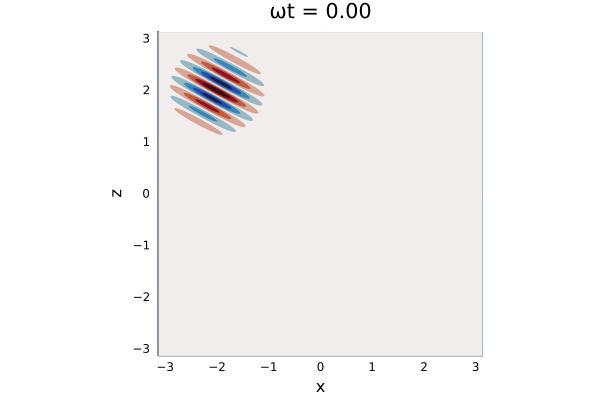

In [17]:
gif(anim, "internal_wave.gif", fps = 8) # hide